**Load Data**

In [1]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Product Capstone/Development/ML/Data.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [3]:
import os

# Directory with number and alphabet pictures
number_0_dir = os.path.join('/tmp/Dataset/0')
number_1_dir = os.path.join('/tmp/Dataset/1')
number_2_dir = os.path.join('/tmp/Dataset/2')
number_3_dir = os.path.join('/tmp/Dataset/3')
number_4_dir = os.path.join('/tmp/Dataset/4')
number_5_dir = os.path.join('/tmp/Dataset/5')
number_6_dir = os.path.join('/tmp/Dataset/6')
number_7_dir = os.path.join('/tmp/Dataset/7')
number_8_dir = os.path.join('/tmp/Dataset/8')
number_9_dir = os.path.join('/tmp/Dataset/9')
A_dir = os.path.join('/tmp/Dataset/A')
B_dir = os.path.join('/tmp/Dataset/B')
C_dir = os.path.join('/tmp/Dataset/C')
D_dir = os.path.join('/tmp/Dataset/D')
E_dir = os.path.join('/tmp/Dataset/E')
F_dir = os.path.join('/tmp/Dataset/F')
G_dir = os.path.join('/tmp/Dataset/G')
H_dir = os.path.join('/tmp/Dataset/H')
I_dir = os.path.join('/tmp/Dataset/I')
J_dir = os.path.join('/tmp/Dataset/J')
K_dir = os.path.join('/tmp/Dataset/K')
L_dir = os.path.join('/tmp/Dataset/L')
M_dir = os.path.join('/tmp/Dataset/M')
N_dir = os.path.join('/tmp/Dataset/N')
O_dir = os.path.join('/tmp/Dataset/O')
P_dir = os.path.join('/tmp/Dataset/P')
Q_dir = os.path.join('/tmp/Dataset/Q')
R_dir = os.path.join('/tmp/Dataset/R')
S_dir = os.path.join('/tmp/Dataset/S')
T_dir = os.path.join('/tmp/Dataset/T')
U_dir = os.path.join('/tmp/Dataset/U')
V_dir = os.path.join('/tmp/Dataset/V')
W_dir = os.path.join('/tmp/Dataset/W')
X_dir = os.path.join('/tmp/Dataset/X')
Y_dir = os.path.join('/tmp/Dataset/Y')
Z_dir = os.path.join('/tmp/Dataset/Z')

In [4]:
number_0 = os.listdir(number_0_dir)
number_1 = os.listdir(number_1_dir)
number_2 = os.listdir(number_2_dir)
number_3 = os.listdir(number_3_dir)
number_4 = os.listdir(number_4_dir)
number_5 = os.listdir(number_5_dir)
number_6 = os.listdir(number_6_dir)
number_7 = os.listdir(number_7_dir)
number_8 = os.listdir(number_8_dir)
number_9 = os.listdir(number_9_dir)
alp_A = os.listdir(A_dir)
alp_B = os.listdir(B_dir)
alp_C = os.listdir(C_dir)
alp_D = os.listdir(D_dir)
alp_E = os.listdir(E_dir)
alp_F = os.listdir(F_dir)
alp_G = os.listdir(G_dir)
alp_H = os.listdir(H_dir)
alp_I = os.listdir(I_dir)
alp_J = os.listdir(J_dir)
alp_K = os.listdir(K_dir)
alp_L = os.listdir(L_dir)
alp_M = os.listdir(M_dir)
alp_N = os.listdir(N_dir)
alp_O = os.listdir(O_dir)
alp_P = os.listdir(P_dir)
alp_Q = os.listdir(Q_dir)
alp_R = os.listdir(R_dir)
alp_S = os.listdir(S_dir)
alp_T = os.listdir(T_dir)
alp_U = os.listdir(U_dir)
alp_V = os.listdir(V_dir)
alp_W = os.listdir(W_dir)
alp_X = os.listdir(X_dir)
alp_Y = os.listdir(Y_dir)
alp_Z = os.listdir(Z_dir)

In [5]:
# Printing the first 10 items in each directory
print(f'0: {number_0[:5]}')
print(f'1: {number_1[:5]}')
print(f'2: {number_2[:5]}')
print(f'3: {number_3[:5]}')
print(f'4: {number_4[:5]}')
print(f'5: {number_5[:5]}')
print(f'6: {number_6[:5]}')
print(f'7: {number_7[:5]}')
print(f'8: {number_8[:5]}')
print(f'9: {number_9[:5]}')
print(f'A: {alp_A[:5]}')
print(f'B: {alp_B[:5]}')
print(f'C: {alp_C[:5]}')
print(f'D: {alp_D[:5]}')
print(f'E: {alp_E[:5]}')
print(f'F: {alp_F[:5]}')
print(f'G: {alp_G[:5]}')
print(f'H: {alp_H[:5]}')
print(f'I: {alp_I[:5]}')
print(f'J: {alp_J[:5]}')
print(f'K: {alp_K[:5]}')
print(f'L: {alp_L[:5]}')
print(f'M: {alp_M[:5]}')
print(f'N: {alp_N[:5]}')
print(f'O: {alp_O[:5]}')
print(f'P: {alp_P[:5]}')
print(f'Q: {alp_Q[:5]}')
print(f'R: {alp_R[:5]}')
print(f'S: {alp_S[:5]}')
print(f'T: {alp_T[:5]}')
print(f'U: {alp_U[:5]}')
print(f'V: {alp_V[:5]}')
print(f'W: {alp_W[:5]}')
print(f'X: {alp_X[:5]}')
print(f'Y: {alp_Y[:5]}')
print(f'Z: {alp_Z[:5]}')

0: ['0_24_rotate_2.jpeg', '0_70_rotate_4.jpeg', 'IMG_4370.JPG', 'IMG_4735.JPG', '0_12_rotate_17.jpeg']
1: ['1_52_rotate_5.jpeg', '1_68_rotate_9.jpeg', '1_39_rotate_7.jpeg', 'IMG_4329.JPG', 'IMG_4544.JPG']
2: ['2_22_rotate_9.jpeg', 'IMG_4268.JPG', '2_42_rotate_3.jpeg', '2_48_rotate_2.jpeg', '2_51_rotate_3.jpeg']
3: ['3_64_rotate_3.jpeg', '3_28_rotate_3.jpeg', '3_41_rotate_10.jpeg', '3_50_rotate_9.jpeg', 'IMG_4469.JPG']
4: ['4_2_rotate_3.jpeg', '4_17_rotate_8.jpeg', 'IMG_1203.JPG', '4_4_rotate_2.jpeg', 'IMG_4800.JPG']
5: ['IMG_5892.JPG', '5_28_rotate_1.jpeg', '5_69_rotate_7.jpeg', '5_65_rotate_3.jpeg', 'IMG_4124.JPG']
6: ['6_36_rotate_6.jpeg', '6_67_rotate_9.jpeg', 'IMG_5752.JPG', '6_38_rotate_5.jpeg', 'IMG_4085.JPG']
7: ['7_30_rotate_6.jpeg', 'IMG_4611.JPG', '7_37_rotate_5.jpeg', '7_13_rotate_5.jpeg', '7_69_rotate_10.jpeg']
8: ['8_2_rotate_7.jpeg', '8_68_rotate_7.jpeg', '8_26_rotate_6.jpeg', '8_29_rotate_6.jpeg', '8_17_rotate_5.jpeg']
9: ['9_55_rotate_4.jpeg', '9_44_rotate_1.jpeg', '9_3

In [6]:
# Concatenate paths to each directory
total_data = [
    number_0_dir, number_1_dir, number_2_dir, number_3_dir, number_4_dir, number_5_dir,
    number_6_dir, number_7_dir, number_8_dir, number_9_dir, A_dir, B_dir, C_dir, D_dir,
    E_dir, F_dir, G_dir, H_dir, I_dir, J_dir, K_dir, L_dir, M_dir, N_dir, O_dir, P_dir,
    Q_dir, R_dir, S_dir, T_dir, U_dir, V_dir, W_dir, X_dir, Y_dir, Z_dir
]

# Initialize the variable for the total number of images
total_images = 0

# Iterate through all directories and count the number of files
for total in total_data:
    total_images += len(os.listdir(total))

print(f'Total images: {total_images}')

Total images: 88033


**Split Data**

In [7]:
import random
import os
from shutil import copyfile

def split_data(source, training, validation, split_size):
    files = os.listdir(source)
    files = [file for file in files if os.path.getsize(os.path.join(source, file)) > 0]

    # Calculate lengths for each set
    num_files = len(files)
    num_training = int(num_files * split_size)

    # Shuffle the files
    random.shuffle(files)

    # Split into sets
    training_set = files[:num_training]
    validation_set = files[num_training:]

    # Copy files to respective directories
    for filename in training_set:
        this_file = os.path.join(source, filename)
        destination = os.path.join(training, filename)
        copyfile(this_file, destination)

    for filename in validation_set:
        this_file = os.path.join(source, filename)
        destination = os.path.join(validation, filename)
        copyfile(this_file, destination)

# Define source and destination directories
source_dir = "/tmp/Dataset/"
training_dir = "/tmp/training/"
validation_dir = "/tmp/validation/"

# Define split size as a float (training_size)
split_size = 0.8

# Iterate over each label directory
for label in os.listdir(source_dir):
    label_source_dir = os.path.join(source_dir, label)
    label_training_dir = os.path.join(training_dir, label)
    label_validation_dir = os.path.join(validation_dir, label)

    # Create training and validation directories if they don't exist
    os.makedirs(label_training_dir, exist_ok=True)
    os.makedirs(label_validation_dir, exist_ok=True)

    # Split data for each label
    split_data(label_source_dir, label_training_dir, label_validation_dir, split_size)

In [8]:
# Define directories
training_dir = "/tmp/training/"
validation_dir = "/tmp/validation/"

# Function to count images in subdirectories
def count_images_in_subdirs(directory):
    count = 0
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        count += len(os.listdir(label_dir))
    return count

# Count images in training, testing, and validation directories
num_training_images = count_images_in_subdirs(training_dir)
num_validation_images = count_images_in_subdirs(validation_dir)

# Print the counts
print("Number of training images:", num_training_images)
print("Number of validation images:", num_validation_images)

Number of training images: 70401
Number of validation images: 17632


**Data Augmentation**

In [9]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
training_dir = "/tmp/training/"
validation_dir = "/tmp/validation/"


# Count images in training and validation directories
num_training_images = count_images_in_subdirs(training_dir)
num_validation_images = count_images_in_subdirs(validation_dir)

# Print the counts
print("Number of training images:", num_training_images)
print("Number of validation images:", num_validation_images)
print("")

# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the data
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(150, 150),
    batch_size=32,  # Adjust based on your hardware capabilities
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb',
    seed=42
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,  # Adjust based on your hardware capabilities
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Check a few batches from the generators to ensure everything is working fine
for data_batch, labels_batch in train_generator:
    print("")
    print('Training data batch shape:', data_batch.shape)
    print('Training labels batch shape:', labels_batch.shape)
    print("")
    break

for data_batch, labels_batch in validation_generator:
    print('Validation data batch shape:', data_batch.shape)
    print('Validation labels batch shape:', labels_batch.shape)
    break

Number of training images: 70401
Number of validation images: 17632

Found 70401 images belonging to 36 classes.
Found 17632 images belonging to 36 classes.

Training data batch shape: (32, 150, 150, 3)
Training labels batch shape: (32, 36)

Validation data batch shape: (32, 150, 150, 3)
Validation labels batch shape: (32, 36)


**Examine and Visualize Dataset**

In [10]:
labels = list(train_generator.class_indices.keys())
print(labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


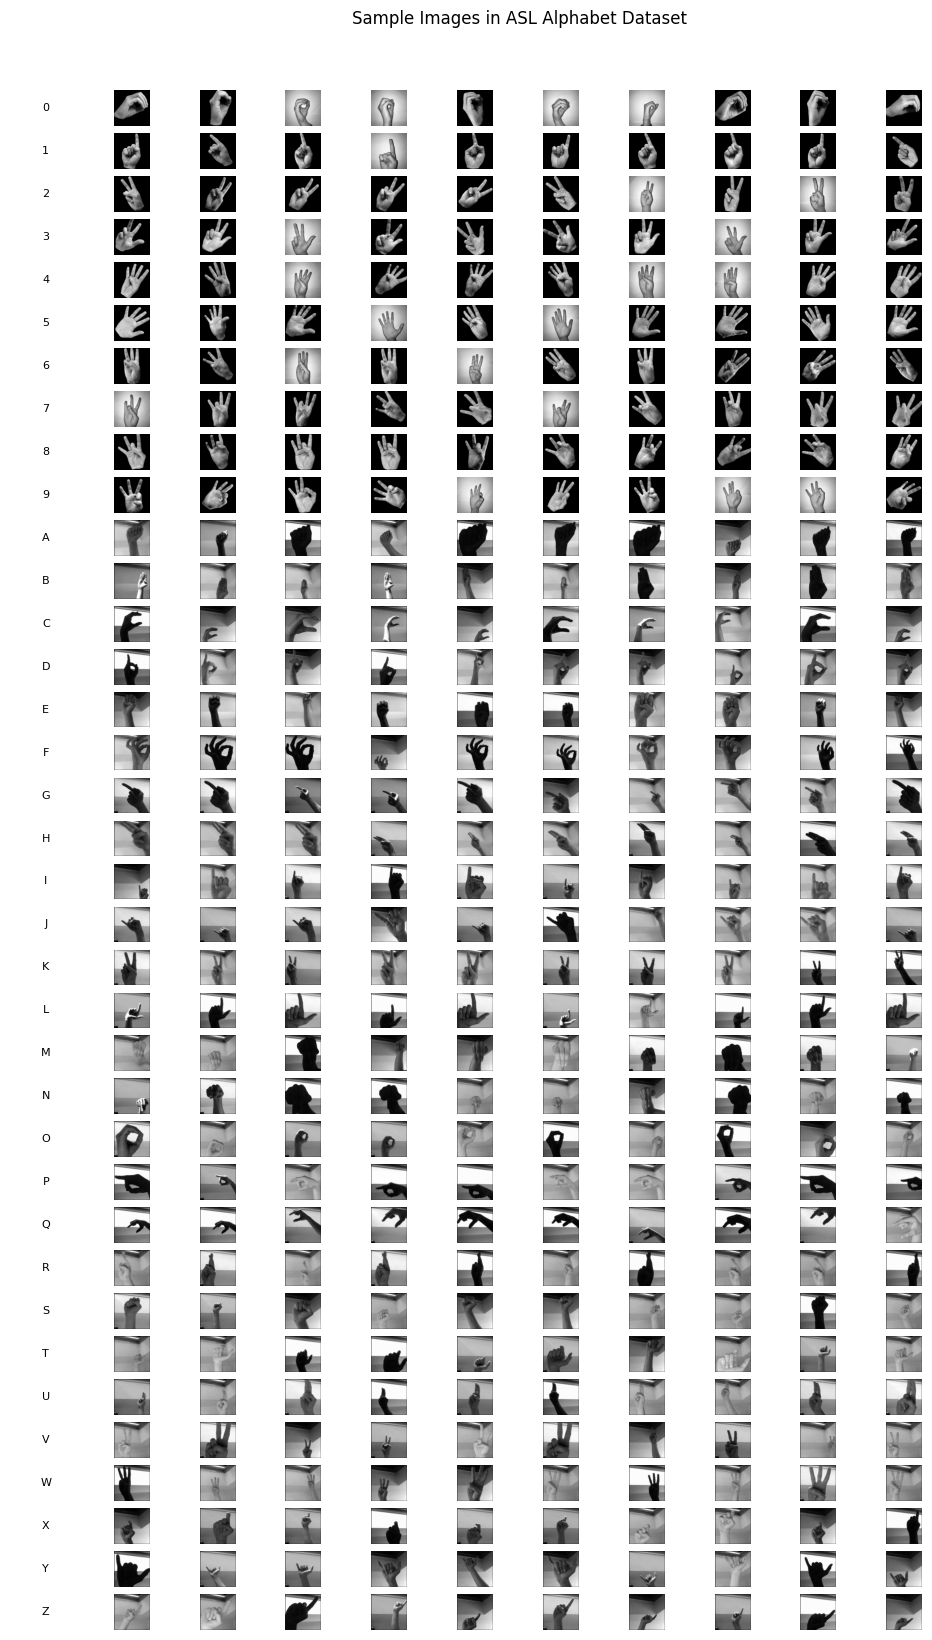

In [11]:
import cv2
import matplotlib.pyplot as plt

train_path = training_dir
def sample_images(labels):
    # Create Subplots
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 11, figsize=(y_size, 20))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(train_path, label)
        list_files = os.listdir(label_path)

        for j in range(10):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2GRAY)
            axs[i, j+1].imshow(img_label, cmap='gray')
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.55, y=0.92)

    # Show
    plt.imshow(img_label, cmap='gray')
    plt.axis('off')
    plt.show()

sample_images(labels[:36])

**CREATE MODEL**

In [12]:
# from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.layers import Flatten, Dense, Dropout, Reshape, Conv2DTranspose, BatchNormalization
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.applications import VGG16

In [13]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [14]:
pretrainedModel = tf.keras.applications.MobileNetV2(
    input_shape=(150, 150, 3),
     include_top=False,
     weights='imagenet'
)
pretrainedModel.trainable = False

inputs = pretrainedModel.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer_adam = tf.keras.optimizers.Adam(learning_rate = 0.005)

9406464/9406464 [==============================] - 0s 0us/step


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']        

In [16]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.92):
            print("\n Accuracy is more than 95%, stopping...")
            self.model.stop_training = True

callback = myCallback()

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[callback]
 )

Epoch 1/50
2201/2201 [==============================] - 522s 234ms/step - loss: 1.3725 - accuracy: 0.5764 - val_loss: 0.6860 - val_accuracy: 0.7803
Epoch 2/50
2201/2201 [==============================] - 495s 225ms/step - loss: 0.9619 - accuracy: 0.6984 - val_loss: 0.6382 - val_accuracy: 0.8060
Epoch 3/50
2201/2201 [==============================] - 493s 224ms/step - loss: 0.8841 - accuracy: 0.7234 - val_loss: 0.5683 - val_accuracy: 0.8220
Epoch 4/50
2201/2201 [==============================] - 496s 225ms/step - loss: 0.8340 - accuracy: 0.7388 - val_loss: 0.5679 - val_accuracy: 0.8327
Epoch 5/50
2201/2201 [==============================] - 491s 223ms/step - loss: 0.8107 - accuracy: 0.7472 - val_loss: 0.5169 - val_accuracy: 0.8408
Epoch 6/50
2201/2201 [==============================] - 496s 226ms/step - loss: 0.7840 - accuracy: 0.7574 - val_loss: 0.5101 - val_accuracy: 0.8437
Epoch 7/50
2201/2201 [==============================] - 526s 239ms/step - loss: 0.7747 - accuracy: 0.7634 - val_

In [ ]:
# The code below is to save model as a .h5 file.
if __name__ == '__main__':
    model.save("model.h5")